In [142]:
import sys
sys.path.append("../")

In [143]:
from utils.helper_functions import *

In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [53]:
speeches = pandas.read_excel(r"../data/presidential_speeches.xlsx")
speeches = speeches.rename(columns={'Unnamed: 0': 'title', 'President': 'president', 'Date': 'date', 'Speech': 'text'})
speeches['subtype'] = 'Speech'
print(speeches.shape)
speeches.head(2)

(382, 5)


,title,president,date,text,subtype
0,january-20-2021-inaugural-address,Joe Biden,"January 20, 2021","\n \n\n\n\n\n\nChief Justice Roberts, Vic...",Speech
1,january-19-2021-farewell-address,Donald Trump,"January 19, 2021",\n \n\n\n\n\n\nMy fellow Americans: Four ...,Speech


In [54]:
orders = pandas.read_csv("../data/exec_orders_w_text")
orders = orders.rename(columns={'publication_date': 'date', 'order_text': 'text'})
print(orders.shape)
orders.head(2)

(1042, 16)


,Unnamed: 0,citation,document_number,end_page,html_url,pdf_url,type,subtype,date,signing_date,start_page,title,disposition_notes,executive_order_number,president,text
0,0,82 FR 8115,2017-01623,8129,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/23/2017,01/17/2017,8115,"Amending the Civil Service Rules, Executive Or...","Amends: EO 13467, June 30, 2008; EO 13488, Jan...",13764.0,barack_obama,\n\nTitle 3—\nThe President\n\nExecutive Order...
1,1,82 FR 7619,2017-01487,7620,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/19/2017,01/13/2017,7619,Providing an Order of Succession Within the De...,"Revokes: EO 13557, November 4, 2010\nRevoked b...",13762.0,barack_obama,"\n\n\nExecutive Order 13762 of January 13, 201..."


In [55]:
data = speeches.append(orders[['title', 'president', 'date', 'text', 'subtype']])
data = data[data['text'].notna()]
print(data.shape)
data.head(2)

(1221, 5)


,title,president,date,text,subtype
0,january-20-2021-inaugural-address,Joe Biden,"January 20, 2021","\n \n\n\n\n\n\nChief Justice Roberts, Vic...",Speech
1,january-19-2021-farewell-address,Donald Trump,"January 19, 2021",\n \n\n\n\n\n\nMy fellow Americans: Four ...,Speech


In [56]:
colordict = {
'Speech': 'red',
'Executive Order': 'orange'
    }
colors_a = [colordict[c] for c in data['subtype']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('Speech', 'red'), ('Executive Order', 'orange')])


## Speeches vs. Executive Orders are in their separate clusters

Number of clusters:  2


Evaluation Metrics: 
Homogeneity: 0.967
Completeness: 0.971
V-measure: 0.969
Adjusted Rand Score: 0.987


Top terms per cluster:
Cluster 0:
 people
 world
 american
 peace
 ve
 applause
 new
 know
 years
 country


Cluster 1:
 agency
 amended
 council
 director
 property
 pursuant
 information
 services
 consistent
 emergency






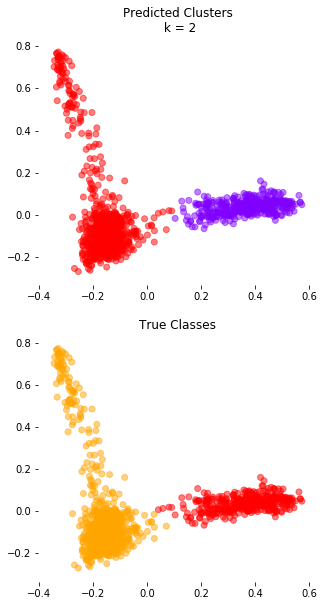

Number of clusters:  3


Evaluation Metrics: 
Homogeneity: 0.967
Completeness: 0.701
V-measure: 0.813
Adjusted Rand Score: 0.804


Top terms per cluster:
Cluster 0:
 people
 world
 american
 peace
 ve
 applause
 new
 know
 years
 country


Cluster 1:
 agency
 amended
 council
 director
 information
 health
 consistent
 committee
 services
 service


Cluster 2:
 property
 pursuant
 blocked
 treasury
 ieepa
 persons
 interests
 emergency
 prohibitions
 entity






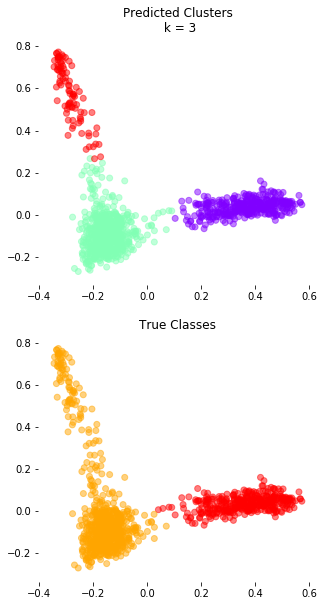

Number of clusters:  4


Evaluation Metrics: 
Homogeneity: 0.974
Completeness: 0.636
V-measure: 0.769
Adjusted Rand Score: 0.758


Top terms per cluster:
Cluster 0:
 property
 pursuant
 blocked
 treasury
 ieepa
 persons
 interests
 emergency
 prohibitions
 entity


Cluster 1:
 people
 world
 american
 peace
 ve
 applause
 new
 know
 years
 country


Cluster 2:
 schedule
 pay
 rates
 basic
 payments
 forth
 senior
 set
 december
 service


Cluster 3:
 agency
 council
 amended
 director
 information
 consistent
 health
 committee
 commission
 services






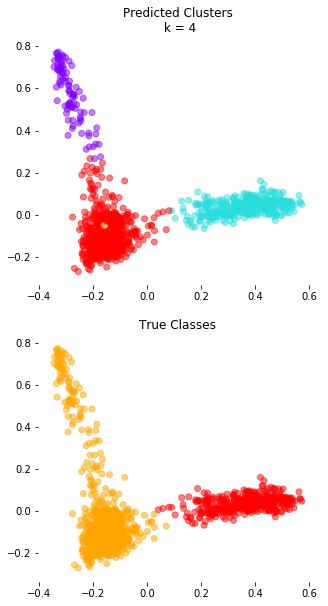

In [57]:
for num in (2,3,4):
    print("Number of clusters: ", num)
    targetDF = data
    textColumn = 'text'
    numCategories = num
    print("\n")
    dataTFVectorizer, dataTFVects, dataKM = KMeans_helper(targetDF, 'subtype', textColumn, numCategories)
    print("\n")
    top_words_by_cluster(dataTFVectorizer, dataKM, numCategories)
    print("\n")
    viz_2D(dataTFVects, dataKM, numCategories, colors_a)

# SWE Results could be used for relevant keywords and presidents

In [58]:
data['tokenized_sents'] = data['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
data['normalized_sents'] = data['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

In [59]:
speechesW2V = gensim.models.word2vec.Word2Vec(data[data['subtype'] =='Speech']['normalized_sents'].sum())
ordersW2V = gensim.models.word2vec.Word2Vec(data[data['subtype'] =='Executive Order']['normalized_sents'].sum())
dataW2V = gensim.models.word2vec.Word2Vec(data['normalized_sents'].sum())

In [60]:
for word in ('race', 'climate', 'health'):
    print('Most similar words to ', word)
    print('In Speeches, are: ')
    print(speechesW2V.most_similar(word)[:5])
    print('In Executive Orders, are: ')
    print(ordersW2V.most_similar(word)[:5])
    print('In Both, are')
    print(dataW2V.most_similar(word)[:5])
    print('\\')

Most similar words to  race
In Speeches, are: 
[('innocent', 0.936743438243866), ('religion', 0.9134871959686279), ('murder', 0.8935733437538147), ('equality', 0.8876535296440125), ('creed', 0.8872072696685791)]
In Executive Orders, are: 
[('sex', 0.9739633798599243), ('color', 0.9302693605422974), ('scapegoat', 0.8955546617507935), ('stereotype', 0.8930492401123047), ('sexual', 0.8893437385559082)]
In Both, are
[('color', 0.8621286749839783), ('religion', 0.8449345827102661), ('sex', 0.8370047807693481), ('murder', 0.8270449042320251), ('ethnic', 0.8251692652702332)]
\
Most similar words to  climate
In Speeches, are: 
[('prove', 0.9770870208740234), ('concrete', 0.9770426750183105), ('complex', 0.9754000306129456), ('catastrophe', 0.9729315042495728), ('possibility', 0.9728935956954956)]
In Executive Orders, are: 
[('resilience', 0.9288477301597595), ('impact', 0.8669130802154541), ('accelerate', 0.837822437286377), ('arctic', 0.8242805004119873), ('strategy', 0.8173335194587708)]
In 

In [61]:
for word in ('race', 'climate', 'health'):
    print('In Speeches')
    print(word, 'to Obama is like')
    print(speechesW2V.most_similar(positive=[word, 'obama'], negative = ['trump'])[:5])
    print('to Trump')
    print(' ')
    print('And,', word, 'to Trump is like')
    print(speechesW2V.most_similar(positive=[word, 'trump'], negative = ['obama'])[:5])
    print('to Obama')
    print(' ')
    
    print('In Executive Orders')
    print(word, 'to Obama is like')
    print(ordersW2V.most_similar(positive=[word, 'obama'], negative = ['trump'])[:5])
    print('to Trump')
    print(' ')
    print('And,', word, 'to Trump is like')
    print(ordersW2V.most_similar(positive=[word, 'trump'], negative = ['obama'])[:5])
    print('to Obama')
    print(' ')
    
    print('In Both')
    print(word, 'to Obama is like')
    print(dataW2V.most_similar(positive=[word, 'obama'], negative = ['trump'])[:5])
    print('to Trump')
    print(' ')
    print('And,', word, 'to Trump is like')
    print(dataW2V.most_similar(positive=[word, 'trump'], negative = ['obama'])[:5])
    print('to Obama')
    print(' ')
    
    print('\\')

In Speeches
race to Obama is like
[('religion', 0.9117399454116821), ('liberty', 0.9015839099884033), ('innocent', 0.8956317901611328), ('equality', 0.8918216228485107), ('happiness', 0.8842995762825012)]
to Trump
 
And, race to Trump is like
[('innocent', 0.9488997459411621), ('murder', 0.9255588054656982), ('viciously', 0.8873424530029297), ('religion', 0.8812828063964844), ('tear', 0.8786818981170654)]
to Obama
 
In Executive Orders
race to Obama is like
[('sex', 0.9600821733474731), ('color', 0.9113768339157104), ('sexual', 0.8596739172935486), ('stereotype', 0.8562098741531372), ('scapegoat', 0.8468770384788513)]
to Trump
 
And, race to Trump is like
[('sex', 0.955172061920166), ('color', 0.916890025138855), ('inherently', 0.9076688289642334), ('scapegoat', 0.9074000716209412), ('stereotype', 0.8953719139099121)]
to Obama
 
In Both
race to Obama is like
[('murder', 0.769406259059906), ('sex', 0.76441490650177), ('religion', 0.7534396648406982), ('color', 0.7491727471351624), ('eth

# Projection Results could also be somewhat interesting

In [151]:
keywords = ['people', 'nation', 'peace', 'climate', 'president', 'executive', 'secretary', 'security']

In [154]:
keywords = keywords + ['healthy', 'fit', 'well', 'sick', 'disease', 'ill']
keywords = keywords + ['regulate', 'public', 'strict', 'deregulate', 'private', 'free']
keywords = keywords + ['climate', 'wind', 'solar', 'green', 'clean', 'economic', 'coal', 'oil', 'energy', 'pollute']

In [155]:
Health = dimension(dataW2V, ['healthy', 'fit', 'well'], ['sick', 'disease', 'ill'])
Regulate = dimension(dataW2V, ['regulate', 'public', 'strict'], ['deregulate', 'private', 'free'])
Climate = dimension(dataW2V, ['climate', 'wind', 'solar', 'green', 'clean'], ['economic', 'coal', 'oil', 'energy', 'pollute'])

In [156]:
Presidents = ['biden', 'trump', 'obama', 'bush', 'clinton', 'reagan','carter', 'ford', 'nixon', 'johnson']

In [157]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Health.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Regulate.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Climate.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'Health': g, 'Regulate': r, 'Climate': c}, index = word_list)
    return df

In [158]:
Presidentsdf = makeDF(dataW2V, Presidents) 

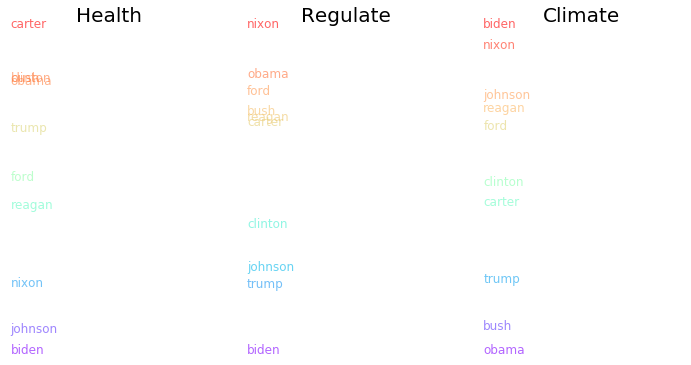

In [159]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Presidentsdf, 'Health')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Presidentsdf, 'Regulate')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Presidentsdf, 'Climate')
plt.show()

# SWE Overtime

In [132]:
data['year'] = data['date'].str[-4:]

In [140]:
data_recent = data[data['year'].isin(['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021'])]      

In [145]:
rawEmbeddings, comparedEmbeddings = compareModels(data_recent, 'year', text_column_name='normalized_sents')

president


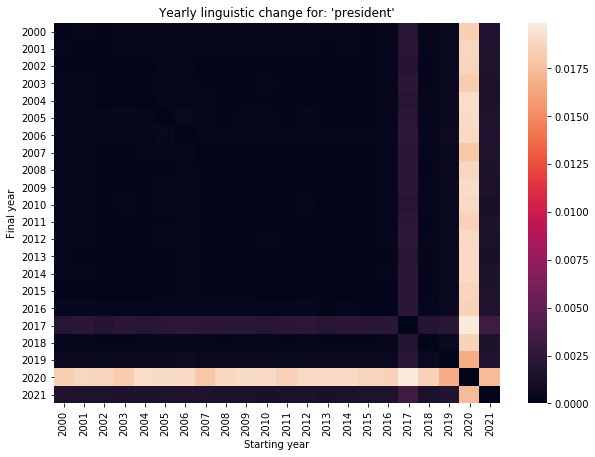

In [146]:
targetWord = 'president'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

equity


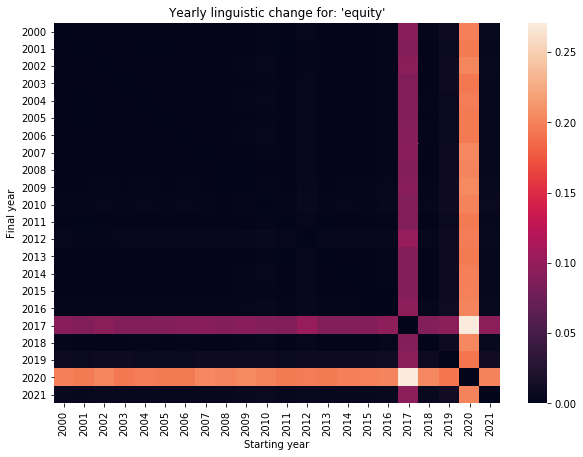

In [147]:
targetWord = 'equity'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

regulation


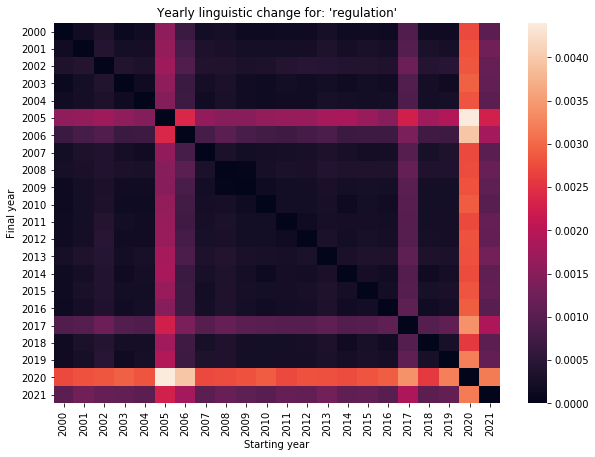

In [148]:
targetWord = 'regulation'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

health


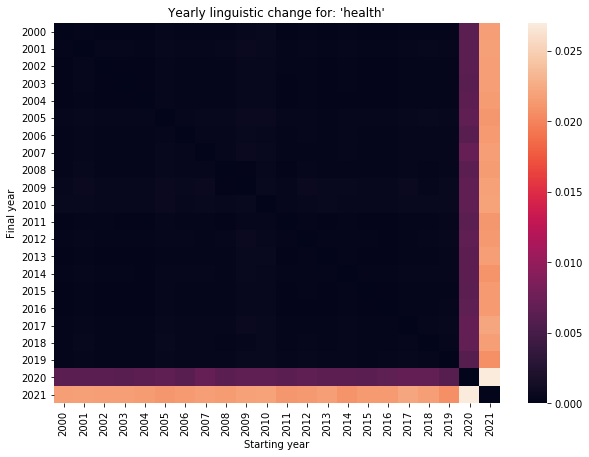

In [149]:
targetWord = 'health'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

energy


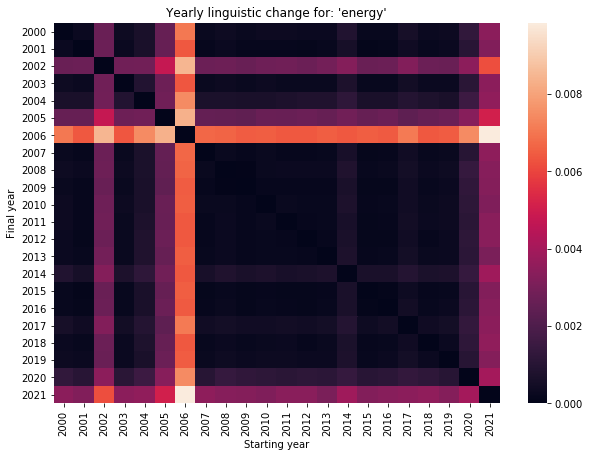

In [150]:
targetWord = 'energy'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

economy


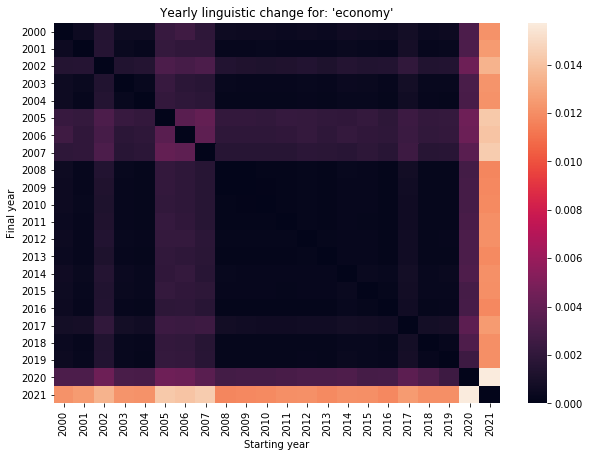

In [160]:
targetWord = 'economy'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()